# Deep Learning Exam: Hotel Review Analysis

This notebook implements the solution for the Hotel Review Analysis task. The goal is to build a deep learning model to predict both the review score (regression) and the review sentiment (bad/good: binary classification) based on the text of the review and other features.

### Setup and Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import math
import nltk
import string
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input, Embedding, Bidirectional, LSTM, Dense,
    Concatenate, Dropout, BatchNormalization, Flatten)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords

# for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

### Data Loading

Downloaded from my GitHub repository.
****
#### Data Reduction for Runtime Efficiency
The hyperparameter search is computationally intensive. Running this search on the full dataset of 13772 samples would result in a runtime that significantly exceeds the "few minutes" guideline mentioned in the assignment's 'PRACTICAL NOTES'.

To ensure the notebook can be executed and evaluated in a reasonable amount of time, I will follow the advice given in the 'PRACTICAL NOTES' section of the assignment, which explicitly permits using a "small subset of input samples".

Therefore, the dataset will be reduced to a random sample of 5000 reviews. This will speed up the tuning process while still allowing the model architecture and the full hyperparameter search workflow to be demonstrated correctly.

In [ ]:
!wget -O data_input.csv https://raw.githubusercontent.com/federicabrasca/deep-learning/refs/heads/main/input_data.csv -q
df_full = pd.read_csv("data_input.csv")
print(f"Original full dataset size: {len(df_full)}")

df = df_full.sample(n=5000, random_state=42).reset_index(drop=True)
print(f"Using a reduced dataset of size: {len(df)}")
df.head()

Original full dataset size: 13772
Using a reduced dataset of size: 5000


,Hotel_Address,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Hotel_number_reviews,Reviewer_number_reviews,Review_Score,Review,Review_Type
0,104 104 Bayswater Rd Westminster Borough Londo...,4/27/2017,8.2,Thistle Kensington Gardens,Ireland,2134,1,7.1,Bigger reception area Did not take breakfast ...,Good_review
1,55 55 61 Westbourne Terrace Westminster Boroug...,6/11/2016,7.3,Shaftesbury Premier London Paddington,Australia,3609,8,6.3,No face washers and poor quality towels,Bad_review
2,350 350 Oxford Street Westminster Borough Lond...,1/9/2016,8.1,Radisson Blu Edwardian Berkshire,Switzerland,1600,1,5.8,Very small room Nice stag,Bad_review
3,Lancaster Lancaster Gate Westminster Borough L...,10/31/2015,7.6,Corus Hotel Hyde Park,United Kingdom,2562,7,5.8,First room was tiny and bathroom was not clea...,Bad_review
4,Via Via Baracchini 12 Milan City Center 20123 ...,4/24/2017,8.3,Brunelleschi Hotel,United Kingdom,3720,3,6.3,The room a little dated A very good breakfast,Bad_review


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hotel_Address            5000 non-null   object 
 1   Review_Date              5000 non-null   object 
 2   Average_Score            5000 non-null   float64
 3   Hotel_Name               5000 non-null   object 
 4   Reviewer_Nationality     5000 non-null   object 
 5   Hotel_number_reviews     5000 non-null   int64  
 6   Reviewer_number_reviews  5000 non-null   int64  
 7   Review_Score             5000 non-null   float64
 8   Review                   5000 non-null   object 
 9   Review_Type              5000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 390.8+ KB


In [ ]:
print("Class distribution for 'Review_Type':")
print(df['Review_Type'].value_counts())

Class distribution for 'Review_Type':
Review_Type
Bad_review     2513
Good_review    2487
Name: count, dtype: int64


The dataset contains 2513 `Bad_review` and 2487 `Good_review` samples.  
This near-perfect balance indicates we can train our sentiment classifier without applying special class weights or resampling strategies.


## Point 1: MODEL
The architecture I would use for this task is a Bidirectional Recurrent Neural Network. This architecture is particularly useful for offline learning settings in which I have the full data available. Here in this case I have the full reviews.

BRNNs take into consideration both the past and the future by performing two different "analyses": one from the starting point to the end and the other one from the end to the starting point (forward and backward directions). RNNs in general, and therefore also BRNNs, are designed to process sequential data and are perfect for tasks in which we have sequences and dependencies among data. In a review the context is of paramount importance and must be taken into consideration for the appropriate time needed.

The key feature of a RNN is its recurrent connection, which allows information to flow in a loop within the network. This recurrent connection allows the RNN to mantain an internal memory, or hidden state, that can capture and remember information from previous steps. The hidden state at each step is combined with the current input to produce the output for that step, then the hidden state is updated and passed to the next step in the sequence.

For the BRNN I would use LSTM layers (long short-term memory -- even though also GRU layers could be implemented) because with the available amount of data, LSTM could perform slightly better due to their slightly higher computational power and architecture. LSTMs are designed to remember information for long durations by incorporating memory cells and gating mechanisms that control the flow of information through the network.

## Point 2: INPUT

### 2a. Preprocessing - Feature Selection

As per the written solution, I will retain the following fields as they are considered potentially useful predictors:
- `Hotel_name`
- `Review_Date`
- `Review`

The following fields will be discarded. Technically they could be considered as well but for consistency with respect to the written solution they won't be retained.
- `Hotel_Address`
- `Hotel_number_reviews`
- `Reviewer_numer_reviews`
- `Reviewer_Nationality`

Also the additional `Average_Score` column won't be retained, as requested by the professor.

In [ ]:
# Retain only the specified columns + target columns for the "final" starting dataframe
retained_cols = [
    'Hotel_Name',
    'Review_Date',
    'Review',
    'Review_Score',
    'Review_Type']

df_processed = df[retained_cols].copy()

### 2a. Preprocessing - Target Labels (Score and Type)

Next, I preprocess the two target variables, `Review_Score` and `Review_Type` to prepare them for training.

- **Review Score (Regression Target):** As planned, I scale the scores from the `[0, 10]` range to the `[0, 1]` range by dividing each score by 10.
- **Review Type (Classification Target):** I encode the string labels `Bad_review` and `Good_review` into integers (0 and 1, respectively).

In [ ]:
df_processed['score_scaled'] = df_processed['Review_Score'] / 10.0
df_processed['type_encoded'] = df_processed['Review_Type'].map({'Bad_review': 0, 'Good_review': 1})

df_processed[['Review_Score', 'score_scaled', 'Review_Type', 'type_encoded']].tail()

,Review_Score,score_scaled,Review_Type,type_encoded
4995,5.8,0.58,Bad_review,0
4996,9.6,0.96,Good_review,1
4997,5.0,0.50,Bad_review,0
4998,10.0,1.00,Good_review,1
4999,5.8,0.58,Bad_review,0


Let's check if all strings in 'type_encoded' column have been correctly remapped (useful to check if there are typos or other values in that column that haven't been considered in the remapping).

In [ ]:
print(df_processed['type_encoded'].unique())

[1 0]


All perfect.

### 2a. Preprocessing - Categorical Input Features (Hotel Name & Date)

- **Hotel Name:** Each unique name is assigned to a unique integer ID.

- **Review Date:** To preserve the valuable time-dependent information, this feature will be treated as ordinal. The dates are converted into a numerical format representing the number of days passed since the earliest review. This numerical feature is then scaled to a `[0, 1]` range.

In [ ]:
label_encoder_hotel = LabelEncoder()
df_processed['hotel_encoded'] = label_encoder_hotel.fit_transform(df_processed['Hotel_Name'])

NUM_HOTELS = len(label_encoder_hotel.classes_)
print(f"Number of unique hotels: {NUM_HOTELS}")


df_processed['date_dt'] = pd.to_datetime(df_processed['Review_Date'], format='%m/%d/%Y')
min_date = df_processed['date_dt'].min()
df_processed['date_ordinal'] = (df_processed['date_dt'] - min_date).dt.days
max_ordinal_date = df_processed['date_ordinal'].max()
df_processed['date_scaled'] = df_processed['date_ordinal'] / max_ordinal_date


display(df_processed[['Hotel_Name', 'hotel_encoded', 'Review_Date', 'date_scaled']].tail())
df_processed = df_processed.drop(columns=['date_dt', 'date_ordinal'])

Number of unique hotels: 1093


,Hotel_Name,hotel_encoded,Review_Date,date_scaled
4995,Mercure Paris Gare De Lyon TGV,702,7/25/2017,0.987671
4996,Phileas Hotel,826,8/9/2015,0.006849
4997,The Premier Notting Hill,1008,10/13/2016,0.597260
4998,Select Hotel,887,8/23/2016,0.527397
4999,Megaro Hotel,681,9/13/2015,0.054795


### 2a. Preprocessing - Text Input Feature (Review)

Now processing the `Review` text as described in the written plan. This involves cleaning, tokenization, conversion to integer sequences and padding.

Some stopwords won't be removed because when dealing with reviews, negations are absolutely fundamental to be retained, otherwise we could end up with something like:

ORIGINAL REV: Expensive room rate that didn't include parking or breakfast (definitely not good...)

CLEANED: expensive room rate include parking breakfast (seems good overall!)

I also add among stopwords the word 'hotel' as here it is not informative!

In [ ]:
MAX_LEN = 400

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Handling contractions: dictionary of common contractions to expand
contractions_dict = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "cannot", "couldn't": "could not", "won't": "will not", "wouldn't": "would not",
    "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "it's": "it is", "that's": "that is", "he's": "he is", "she's": "she is",
    "i'm": "i am", "you're": "you are", "we're": "we are", "they're": "they are"}

spaced_variants = {  #ex: "didn t", "wasn t", etc...
    contr.replace("'", " "): expansion
    for contr, expansion in contractions_dict.items()}

contractions_dict.update(spaced_variants)

# Stopwords not to be removed: if removed the phrase will result "good"/positive
# Last words are INTENTIONALLY written as one word because in case they are
# already grammatically correct (with '  --> ex: wasn't), the code above will
# transform them into the extended negation form (... NOT  --> ex: was not)
# hence the negation will already be retained (see the 'not' as first word here)
negation_words = {
    "not", "no", "never", "none", "nobody", "nothing",
    "neither", "nowhere", "hardly", "scarcely", "barely",
    "cannot", "cant", "dont", "doesnt", "didnt", "wont",
    "wouldnt", "isnt", "arent", "wasnt", "werent"}

stop_words = set(stopwords.words('english'))
stop_words.add('hotel')
stop_words = stop_words.difference(negation_words)

def clean_text(text):
    text = text.lower()
    text = text.replace('-', ' ')

    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)

    words = text.split()

    table = str.maketrans('', '', string.punctuation)

    cleaned_words = []
    for word in words:
        word = word.translate(table)
        if word.isalpha() and word not in stop_words:
            cleaned_words.append(word)

    return " ".join(cleaned_words)


df_processed['review_cleaned'] = df_processed['Review'].apply(clean_text)

# Dictionary creation
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_processed['review_cleaned'])
sequences = tokenizer.texts_to_sequences(df_processed['review_cleaned'])

padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
print("Shape of padded sequences tensor after cleaning:", padded_sequences.shape)

VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f"The full vocabulary size is: {VOCAB_SIZE}")

print("\nExample of cleaning:")
original_review = df_processed['Review'].iloc[0]
cleaned_review = df_processed['review_cleaned'].iloc[0]
print(f"ORIGINAL: {original_review}")
print(f"CLEANED:  {cleaned_review}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Shape of padded sequences tensor after cleaning: (5000, 400)
The full vocabulary size is: 7007

Example of cleaning:
ORIGINAL:  Bigger reception area Did not take breakfast too expensive
CLEANED:  bigger reception area not take breakfast expensive


### 2b. Final Model Input

After preprocessing, my model will accept three inputs:
1.  **Text Input:**
    - **Type:** Integer Tensor
    - **Shape:** `(batch_size, 400)`
    - **Value Domain:** `[0, VOCAB_SIZE-1]`
2.  **Hotel ID Input:**
    - **Type:** Integer Tensor
    - **Shape:** `(batch_size, 1)`
    - **Value Domain:** `[0, NUM_HOTELS-1]`
3.  **Scaled Date Input:**
    - **Type:** Float Tensor
    - **Shape:** `(batch_size, 1)`
    - **Value Domain:** `[0.0, 1.0]`

Since we train models in batches, the final  inputs' dimension always considers this number thus we have three 2D tensors as inputs.

## Point 3: OUTPUT

This section describes the design of the model's output layer. The goal is to predict two different values: a continuous review score (a regression task) and a binary review sentiment (a classification task). This requires a multi-output design with two separate "heads" in the final layer.

The design for the two output layers is as follows:

* **Score output (Regression Head):**
    * A `Dense` layer with 1 unit.
    * Activation function: `sigmoid`.
    * This head will be trained to predict the scaled score. As specified in the preprocessing stage, the original `Review_Score` was scaled to the `[0.0, 1.0]` range specifically to match the output range of the sigmoid function. This is a regression task.

* **Sentiment output (Classification Head):**
    * A `Dense` layer with 1 unit.
    * Activation function: `sigmoid`.
    * This head will be trained to predict the binary sentiment, where `Bad_review` was mapped to `0` and `Good_review` was mapped to `1`. This is a binary classification task.

## Point 4: LOSS

This section describes the loss functions that will be used to train the model, adhering to the written plan. Since the model has two distinct outputs (one for regression and one for classification), a specific loss function is required for each.

The model's overall loss will be the **sum of the individual losses** for each output head ($L_{total} = L_{regression} + L_{classification}$). The goal of the training process is to minimize this combined value through backpropagation.

The choices for the individual loss functions are:

* **Score Prediction (Regression):**
    * **Loss Function:** `Mean Squared Error` (MSE).
    * It measures the average of the squared differences between the predicted scaled score and the true scaled score. It effectively penalizes larger prediction errors, pushing the model toward higher accuracy.

* **Sentiment Prediction (Classification):**
    * **Loss Function:** `Binary Cross-Entropy (BCE)`.
    * It measures how far the predicted probability (a value between 0 and 1) is from the true label (either 0 or 1).

## Point 5: MODEL CONFIGURATION

This section covers the actual implementation of the model's architecture and its configuration for training.

### 5a. Model Composition

* **Multi-Input architecture:** Each type of feature is processed by its own specialized branch. The learned representations from these branches are then merged (concatenated) for a final prediction. This allows the model to learn from all features in parallel. As part of this, the IDs for `Hotel_Name` will be fed into an Embedding layer. This layer learns a dense vector (a meaningful representation) for each hotel, which is far more powerful than using a raw ID. `Review_date` is already a meaningful numerical value (a float between 0.0 and 1.0 representing the review's position on a timeline) so it doesn't need an Embedding layer.
---

### Final Model Architecture Plan

Input definitions, parallel processing branches, a merge layer and a final prediction head.

1.  **Input layers:** Three separate `Input` layers will be defined: one for the padded text sequences, one for the hotel integer IDs and one for the scaled numerical date feature.
2.  **Text branch:** The text input will be processed by an `Embedding` layer followed by a `Bidirectional LSTM` layer to capture contextual information from the reviews.
3.  **Hotel branch:** The hotel ID input will be processed by its own `Embedding` layer to learn a vector representation for each hotel.
4.  **Merge layer:** The outputs of the text branch and the hotel branch will be concatenated along with the scaled date input.
5.  **Dense head:** The merged vector will be passed through `Dense` layer(s) (with `ReLU` activation, `BatchNormalization` and `Dropout` as specified in the original plan) to learn final patterns.
6.  **Output layer:** The final layer will have the two output heads designed in Point 3 (one for the score and one for the sentiment).

### 5b. Model Configuration and Hyperparameter Tuning

In [ ]:
#fixed hyperparameters
MAX_LEN = 400
EMBEDDING_DIM = 128

EMBEDDING_DIM is the size of the dense vector that will be used to represent each unique word in the vocabulary.

Smaller values (32, 64) result in a smaller, faster-to-train model. However, they might not have enough capacity to capture the full complexity and nuanced semantic relationships between words.

Larger values (256, 300) can capture much more detailed relationships but they create a very large Embedding layer. This makes the model slower, require more memory and increases the risk of overfitting.

I will use a value of 128 which is a well-balanced starting point for a moderately sized dataset and vocabulary like this. It provides sufficient capacity to learn meaningful word representations without making the model excessively large or slow to train.

#### Tunable Hyperparameters

As per the original written plan, several hyperparameters should be tuned to find the best model configuration. A search space for them will be defined in the next step, inside the model-building function.

The hyperparameters that will be tuned are:
-   **Batch size**
-   **Learning Rate (`eta`)**
-   **Number of Epochs**
-   **Dropout rate**
-   **Dense Layers**: number of Dense layers after BRNN.

A two-stage grid search will be performed to test all combinations of the chosen hyperparameters.
1.  **A manual `for` loop** will iterate through the `batch_size` values `[32, 64, 128]`.
2.  **KerasTuner's `GridSearch`** will run inside the loop to test all combinations.
3.  An **`EarlyStopping` callback** will be used to automatically find the optimal number of `epochs` for each trial, preventing wasted time and overfitting.

In [ ]:
X_text = padded_sequences
X_hotel = df_processed['hotel_encoded'].values
X_date = df_processed['date_scaled'].values.reshape(-1, 1) # from (13772,) into (13772, 1) as expected

y_score = df_processed['score_scaled'].values
y_type = df_processed['type_encoded'].values

# 80% for training+validation, 20% for testing
X_train_val_text, X_test_text, X_train_val_hotel, X_test_hotel, X_train_val_date, X_test_date, y_train_val_score, y_test_score, y_train_val_type, y_test_type = train_test_split(
    X_text, X_hotel, X_date, y_score, y_type, test_size=0.2, random_state=42, stratify=y_type)

# Splitting the 80% into training and validation
X_train_text, X_val_text, X_train_hotel, X_val_hotel, X_train_date, X_val_date, y_train_score, y_val_score, y_train_type, y_val_type = train_test_split(
    X_train_val_text, X_train_val_hotel, X_train_val_date, y_train_val_score, y_train_val_type, test_size=0.125, random_state=42, stratify=y_train_val_type)

X_train_list = [X_train_text, X_train_hotel, X_train_date]
X_val_list = [X_val_text, X_val_hotel, X_val_date]
X_test_list = [X_test_text, X_test_hotel, X_test_date]

y_train_dict = {'score_output': y_train_score, 'type_output': y_train_type}
y_val_dict = {'score_output': y_val_score, 'type_output': y_val_type}
y_test_dict = {'score_output': y_test_score, 'type_output': y_test_type}

In [ ]:
def build_tuner_model(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    hp_num_layers = hp.Choice('num_layers', values=[1, 2])
    hp_dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.5])

    input_text = Input(shape=(MAX_LEN,), name='text_input')
    input_hotel = Input(shape=(1,), name='hotel_input')
    input_date = Input(shape=(1,), name='date_input')

    embedding_text = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, name='text_embedding')(input_text)
    lstm_out = Bidirectional(LSTM(64), name='bidirectional_lstm')(embedding_text)

    embedding_hotel = Embedding(input_dim=NUM_HOTELS, output_dim=8, name='hotel_embedding')(input_hotel)
    hotel_out = Flatten(name='flatten_hotel')(embedding_hotel)

    concatenated = Concatenate(name='concatenate')([lstm_out, hotel_out, input_date])

    x = concatenated
    for i in range(hp_num_layers):
        x = Dense(64, activation='relu', name=f'shared_dense_{i+1}')(x)
        x = BatchNormalization(name=f'batch_norm_{i+1}')(x)
        x = Dropout(rate=hp_dropout_rate, name=f'dropout_{i+1}')(x)
    final_shared_output = x

    output_score = Dense(1, activation='sigmoid', name='score_output')(final_shared_output)
    output_type = Dense(1, activation='sigmoid', name='type_output')(final_shared_output)

    model = Model(
        inputs=[input_text, input_hotel, input_date],
        outputs=[output_score, output_type])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss={'score_output': 'mean_squared_error', 'type_output': 'binary_crossentropy'},
        metrics={'score_output': 'mae', 'type_output': 'accuracy'})

    return model

# Define the EarlyStopping callback: stop training if the validation loss doesn't improve for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


batch_sizes_to_test = [32, 64, 128]
all_tuners = []

for bs in batch_sizes_to_test:
    print(f"\nTESTING BATCH SIZE: {bs}")

    project_name = f'reviews_bs_{bs}'

    tuner = kt.GridSearch(
        build_tuner_model,
        objective=kt.Objective("val_loss", direction="min"),
        max_trials=8, # 2(lr) * 2(#layers) * 2(dropout) = 8 combinations
        directory='tuner_grid_search',
        project_name=project_name,
        overwrite=True)

    tuner.search(
        X_train_list,
        y_train_dict,
        epochs=3,  #to speed up process
        validation_data=(X_val_list, y_val_dict),
        batch_size=bs,
        callbacks=[early_stopping])

    all_tuners.append(tuner)

Trial 8 Complete [00h 00m 10s]
val_loss: 0.7994772791862488

Best val_loss So Far: 0.5779152512550354
Total elapsed time: 00h 01m 27s


To ensure the entire process completes quickly, as required by the assignment, each trial was run for only three epochs. An `EarlyStopping` callback was included in the setup to demonstrate how a longer-running search would be properly managed by stopping automatically once performance on the validation set plateaus.

## Point 6: MODEL EVALUATION

This section addresses the final point of the assignment: assessing the generalization capabilities of the model on unseen data.

The process is as follows:
1.  **Analyze tuner results:** I will first go through the results of the 24 trials to identify the single best set of hyperparameters based on the validation loss.
2.  **Retrieve the best model:** I will get the best model instance found by the tuner.
3.  **Final evaluation on test set:** Finally, I will evaluate this best model on the held-out test set to get an unbiased measure of its performance, calculating all the metrics specified in the original written plan.

### 6a. Analyzing tuner results

The first step is to find the best hyperparameter combination from the entire search. I will iterate through the results of each tuner (one for each batch size) and find the trial that resulted in the lowest validation loss overall.

In [ ]:
best_tuner = None
best_hyperparameters = None
best_val_loss = float('inf')

for tuner in all_tuners:
    current_best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
    current_val_loss = current_best_trial.score
    current_batch_size = tuner.project_name.split('_')[-1]

    print(f"Results for Batch Size: {current_batch_size}")
    print(f"Best Validation Loss: {current_val_loss:.4f}")
    print("Hyperparameters:")

    for hp, value in current_best_trial.hyperparameters.values.items():
        print(f"  - {hp}: {value}")
    print("-" * 30)

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_tuner = tuner


print("\nOverall best configuration")
best_hyperparameters = best_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best overall validation loss: {best_val_loss:.4f}")
print("Best hyperparameters found:")
for hp, value in best_hyperparameters.values.items():
    print(f"  - {hp}: {value}")
print(f"  - batch_size: {best_tuner.project_name.split('_')[-1]}")

Results for Batch Size: 32
Best Validation Loss: 0.3258
Hyperparameters:
  - learning_rate: 0.001
  - num_layers: 2
  - dropout_rate: 0.2
------------------------------
Results for Batch Size: 64
Best Validation Loss: 0.4755
Hyperparameters:
  - learning_rate: 0.001
  - num_layers: 1
  - dropout_rate: 0.2
------------------------------
Results for Batch Size: 128
Best Validation Loss: 0.5779
Hyperparameters:
  - learning_rate: 0.001
  - num_layers: 2
  - dropout_rate: 0.5
------------------------------

Overall best configuration
Best overall validation loss: 0.3258
Best hyperparameters found:
  - learning_rate: 0.001
  - num_layers: 2
  - dropout_rate: 0.2
  - batch_size: 32


### 6b. Retrieving the best model

Now that the best hyperparameter combination has been identified, I will retrieve the corresponding model instance from the tuner. The tuner automatically saved the weights from the best epoch for this model.

In [ ]:
best_model = best_tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hotel_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 400, 128)  │    896,896 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hotel_embedding     │ (None, 1, 8)      │      8,744 │ hotel_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 128)       │     98,816 │ text_embedding[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_hotel       │ (None, 8)         │          0 │ hotel_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ date_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 137)       │          0 │ bidirectional_ls… │
│ (Concatenate)       │                   │            │ flatten_hotel[0]… │
│                     │                   │            │ date_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_1      │ (None, 64)        │      8,832 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_1        │ (None, 64)        │        256 │ shared_dense_1[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_norm_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_2      │ (None, 64)        │      4,160 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_2        │ (None, 64)        │        256 │ shared_dense_2[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_norm_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_output        │ (None, 1)         │         65 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type_output (Dense) │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,018,090 (3.88 MB)

 Trainable params: 1,017,834 (3.88 MB)

 Non-trainable params: 256 (1.00 KB)

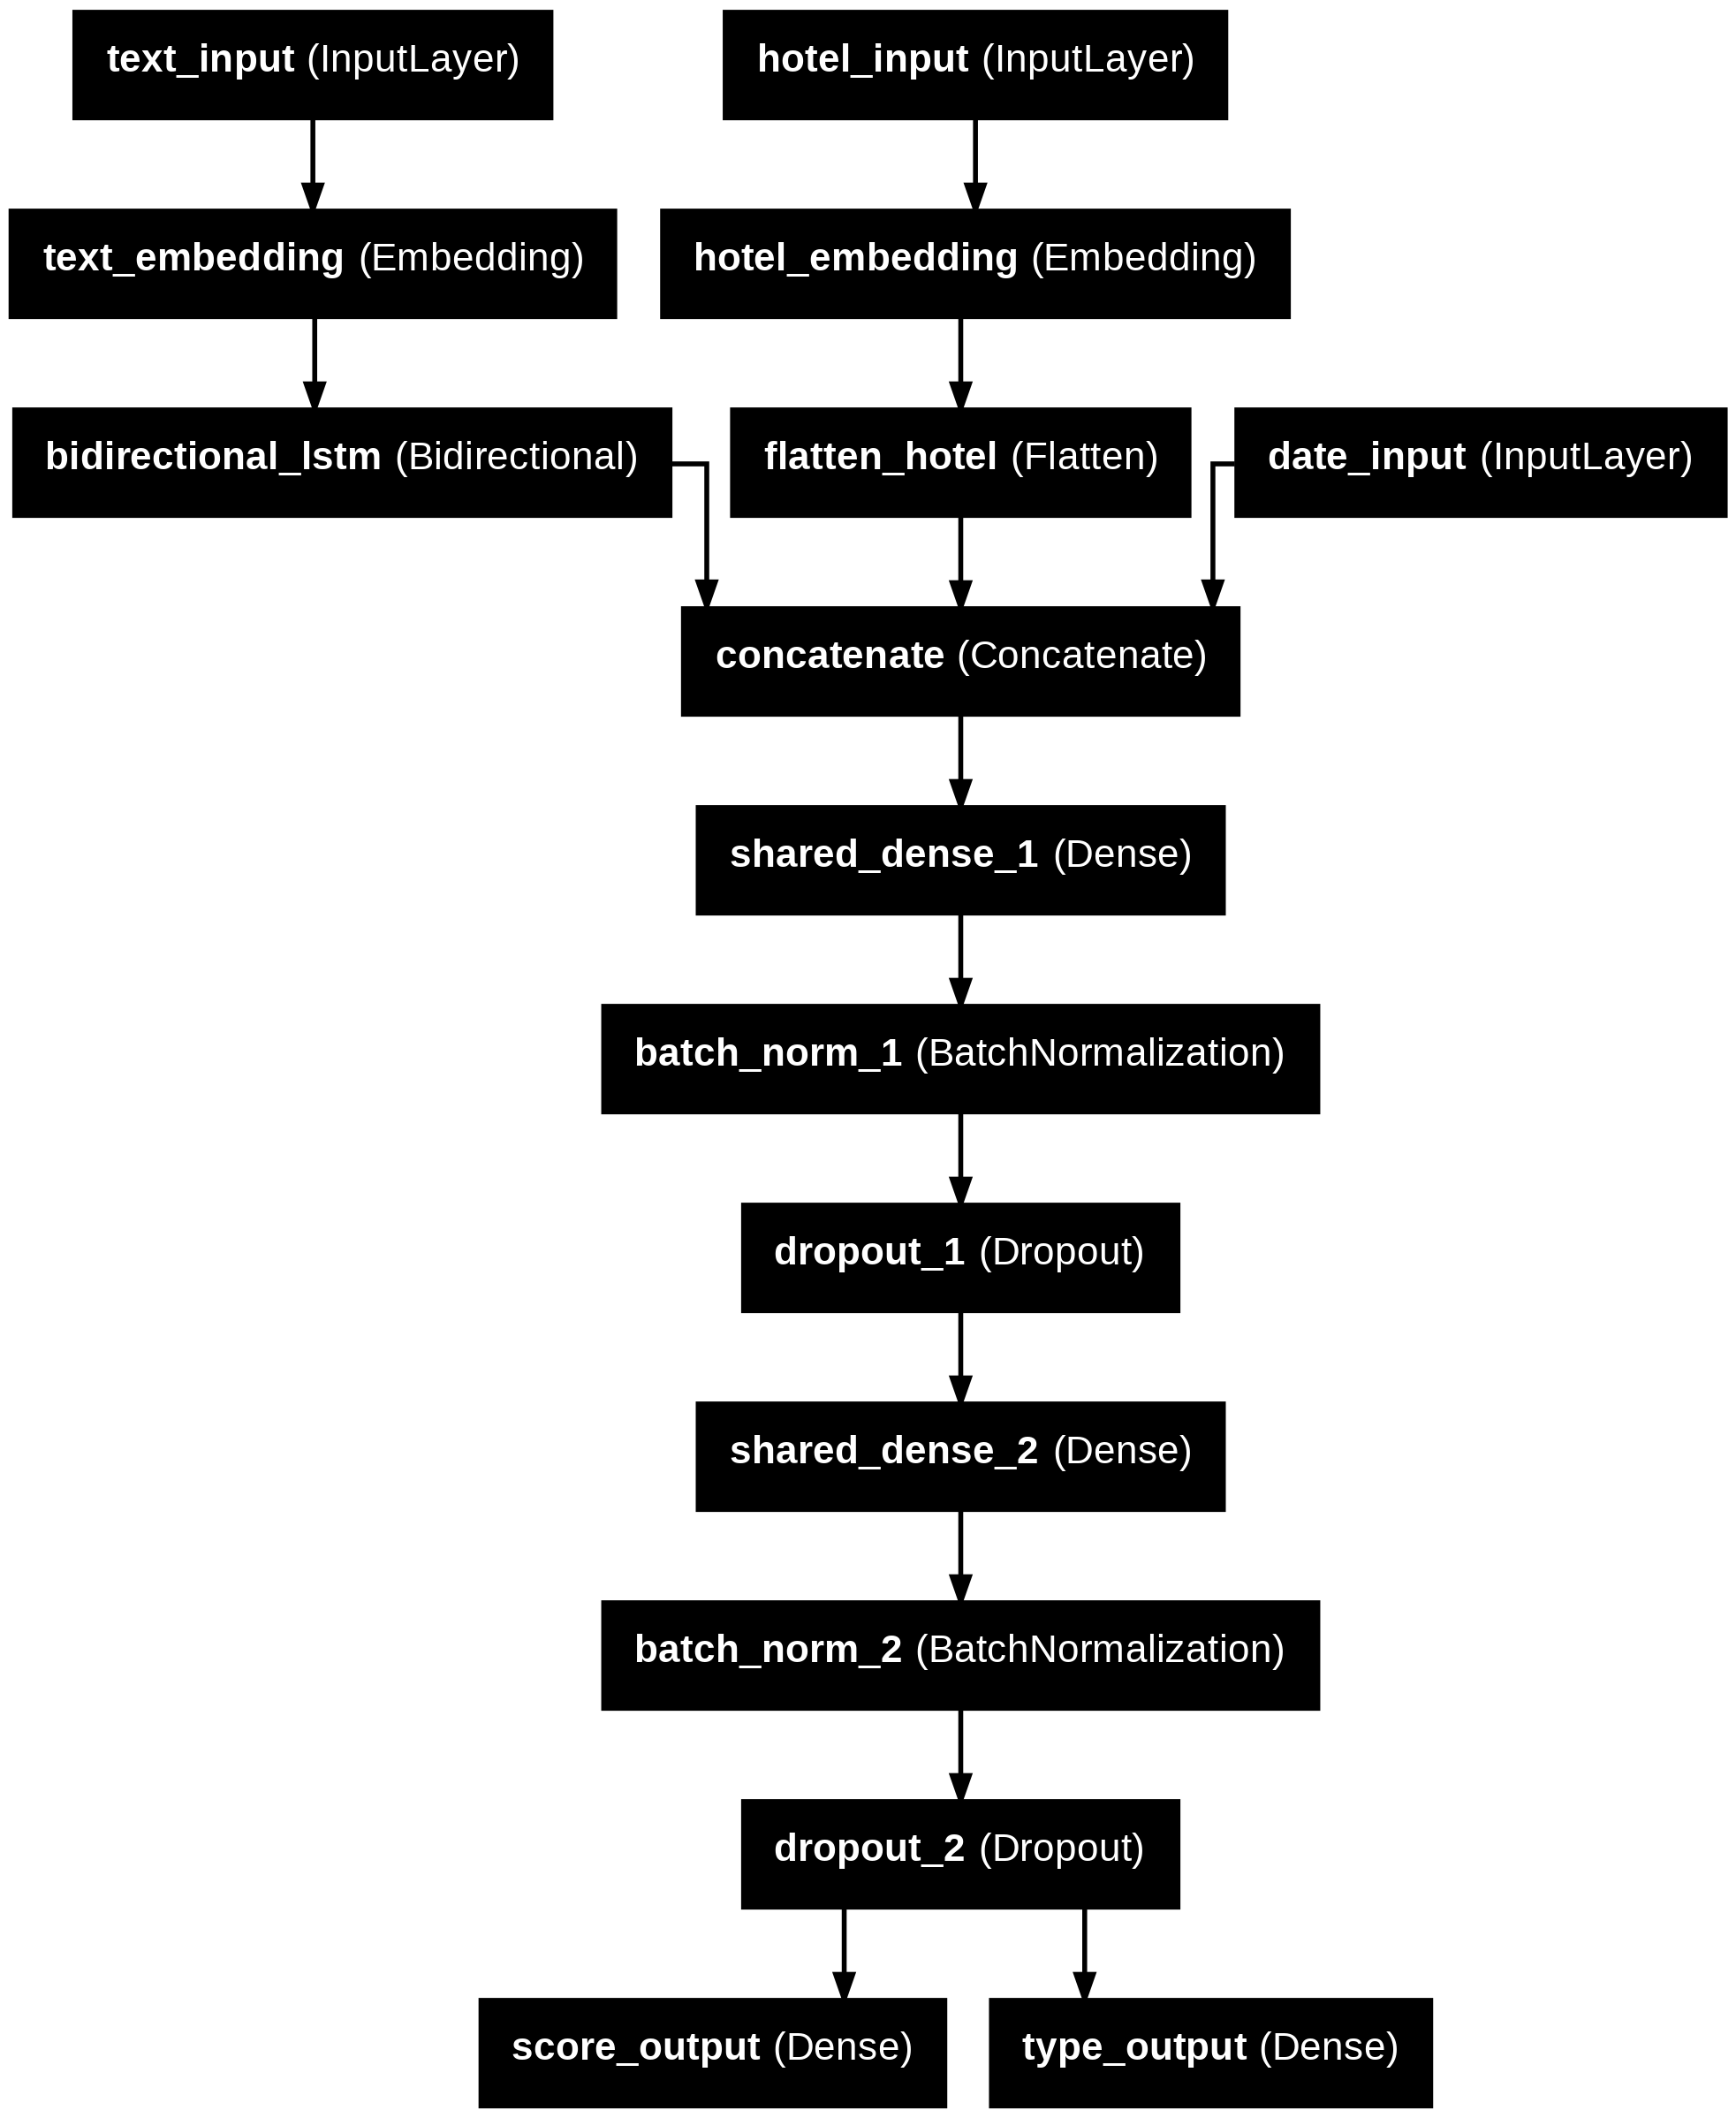

In [ ]:
plot_model(best_model, show_layer_names=True)

### 6c. Training the best model and visualizing learning curves

Before the final evaluation on the test set, I will train the best model configuration one last time on the training data. This will allow me to generate the learning curves to visualize the training process for loss, classification accuracy and regression error (MAE). The `EarlyStopping` callback will ensure the model trains for the optimal number of epochs.

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.1449 - score_output_loss: 0.0256 - score_output_mae: 0.1258 - type_output_accuracy: 0.9565 - type_output_loss: 0.1193 - val_loss: 0.3697 - val_score_output_loss: 0.0485 - val_score_output_mae: 0.1930 - val_type_output_accuracy: 0.8480 - val_type_output_loss: 0.3184
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0977 - score_output_loss: 0.0231 - score_output_mae: 0.1202 - type_output_accuracy: 0.9760 - type_output_loss: 0.0746 - val_loss: 0.4289 - val_score_output_loss: 0.0340 - val_score_output_mae: 0.1489 - val_type_output_accuracy: 0.8600 - val_type_output_loss: 0.3898
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0817 - score_output_loss: 0.0198 - score_output_mae: 0.1095 - type_output_accuracy: 0.9768 - type_output_loss: 0.0619 - val_loss: 0.6066 - val_score_output_loss: 0.0277 - val_score_output_mae: 0.1209 - val_type_output_accuracy: 0.8860 - val_type_output_loss: 0.5751
Epoch 4/30
11

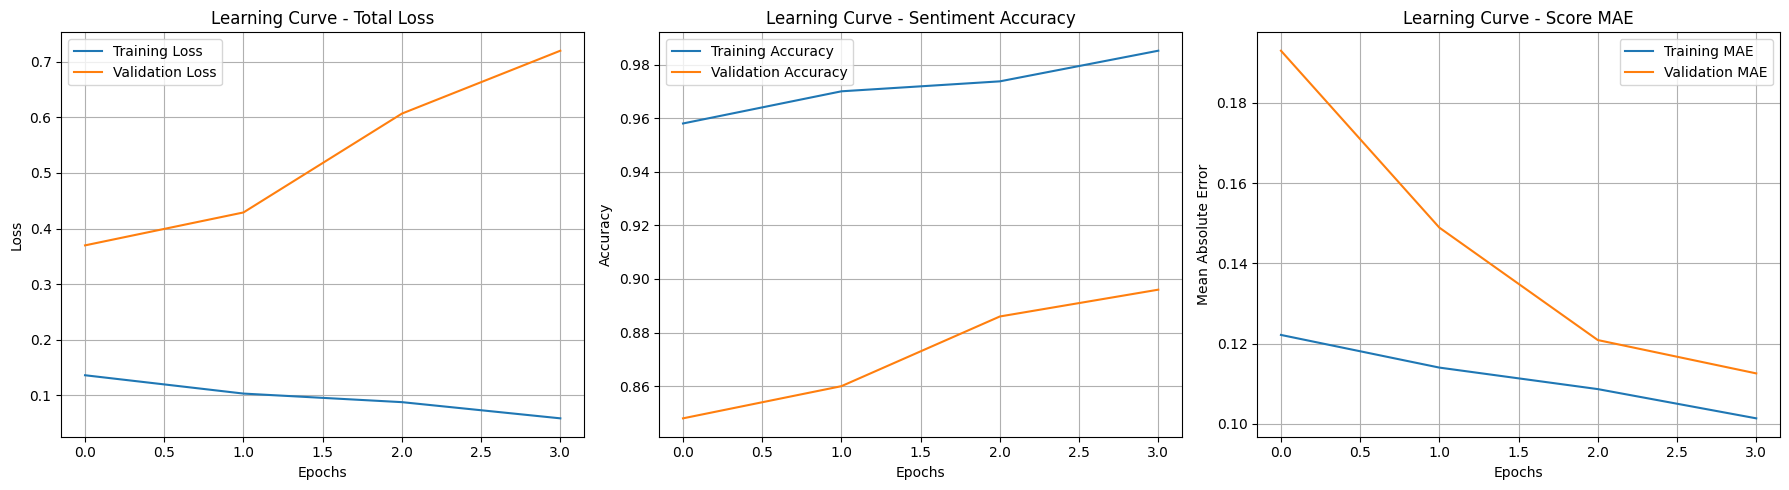

In [ ]:
history = best_model.fit(
    X_train_list,
    y_train_dict,
    epochs=30,
    batch_size=int(best_tuner.project_name.split('_')[-1]),
    validation_data=(X_val_list, y_val_dict),
    callbacks=[early_stopping], # stop when validation loss stops improving
    verbose=1)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve - Total Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['type_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_type_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Sentiment Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['score_output_mae'], label='Training MAE')
plt.plot(history.history['val_score_output_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curve - Score MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Even though here final performance doesn't matter (I have sped up training by using smaller dataset and less epochs), plotting training vs. validation loss and accuracy+MAE is a standard step for checking performnce over epochs.

### 6d. Final Evaluation on the Test Set

This is the final step. The best model's generalization capability is now assessed on the held-out test set, which it has never seen before during training or tuning. I will calculate and display all the metrics specified in the original written plan.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3473 - score_output_loss: 0.0461 - score_output_mae: 0.1878 - type_output_accuracy: 0.8632 - type_output_loss: 0.3013
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Final Regression Metrics (Review Score)
Test Set MSE: 0.0463
Test Set RMSE: 0.2153
Test Set MAE: 0.1872

Final Classification Metrics (Review Type)
Test Set Accuracy: 0.8760

Classification Report:
              precision    recall  f1-score   support

  Bad_review       0.84      0.93      0.88       503
 Good_review       0.92      0.82      0.87       497

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000


Confusion Matrix:


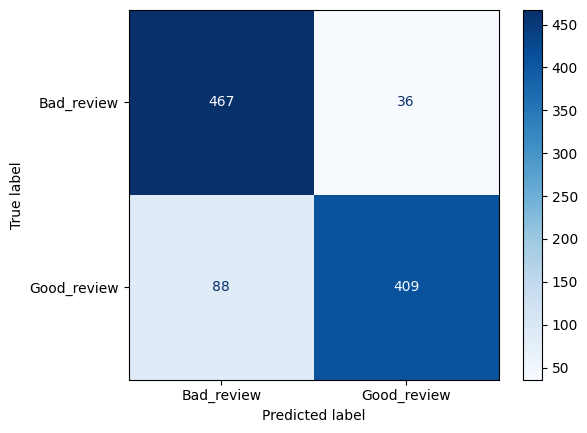

In [ ]:
test_results = best_model.evaluate(X_test_list, y_test_dict)

test_loss_total = test_results[0]
test_loss_score = test_results[1]
test_loss_type = test_results[2]
test_mae_score = test_results[3]
test_accuracy_type = test_results[4]
test_rmse_score = math.sqrt(test_loss_score)

y_pred_list = best_model.predict(X_test_list)
score_preds = y_pred_list[0]
type_preds_prob = y_pred_list[1]
type_preds_class = (type_preds_prob > 0.5).astype(int)

print("\nFinal Regression Metrics (Review Score)")
print(f"Test Set MSE: {test_loss_score:.4f}")
print(f"Test Set RMSE: {test_rmse_score:.4f}")
print(f"Test Set MAE: {test_mae_score:.4f}")

print("\nFinal Classification Metrics (Review Type)")
print(f"Test Set Accuracy: {test_accuracy_type:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_dict['type_output'], type_preds_class, target_names=['Bad_review', 'Good_review']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_dict['type_output'], type_preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad_review', 'Good_review'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### 6e. Prediction on a Single Example

Finally, to see how the best model behaves on a single, concrete example, I will select one review from the test set. I will preprocess this single data point, feed it to the model to get a prediction for both score and sentiment and then compare the model's predictions to the actual true labels.

In [ ]:
idx = 0

text_batch  = X_test_list[0][idx:idx+1]     # shape (1, 400)
hotel_batch = X_test_list[1][idx:idx+1]     # shape (1,)
date_batch  = X_test_list[2][idx:idx+1]     # shape (1, 1)

score_pred_scaled, type_pred_prob = best_model.predict(
    [text_batch, hotel_batch, date_batch],
    verbose=0)

# Rescale & decode
pred_score = float(score_pred_scaled[0] * 10)
pred_type  = 'Good_review' if type_pred_prob[0,0] > 0.5 else 'Bad_review'

true_score = float(y_test_dict['score_output'][idx] * 10)
true_type  = 'Good_review' if y_test_dict['type_output'][idx] == 1 else 'Bad_review'

mask = (
    (df_processed['hotel_encoded'] == hotel_batch[0]) &
    np.isclose(df_processed['date_scaled'],  date_batch[0,0]) &
    np.isclose(df_processed['score_scaled'], y_test_dict['score_output'][idx]))
if mask.any():
    original_review = df_processed.loc[mask, 'Review'].iat[0]
else:
    original_review = "<couldn't find original text>"


print("Single Test Sample\n")
print("Review text:")
print(f"{original_review}\n")
print(f"Score → Predicted: {pred_score:.2f} / 10    |    Actual: {true_score:.2f} / 10")
print(f"Sentiment → Predicted: {pred_type} (p={type_pred_prob[0,0]:.2f})    |    Actual: {true_type}\n")

Single Test Sample

Review text:
 all is excellent 

Score → Predicted: 7.13 / 10    |    Actual: 10.00 / 10
Sentiment → Predicted: Good_review (p=0.86)    |    Actual: Good_review

